## Data Visualization Project Information 

In my independent project, I utilized various Scikit-Learn models to demonstrate my understanding of data visualization and how to extract insights from model results.

# Apple (AAPL) Stock Price Prediction Using Past 30 Days Data

## 1: Using Support Vector Regression

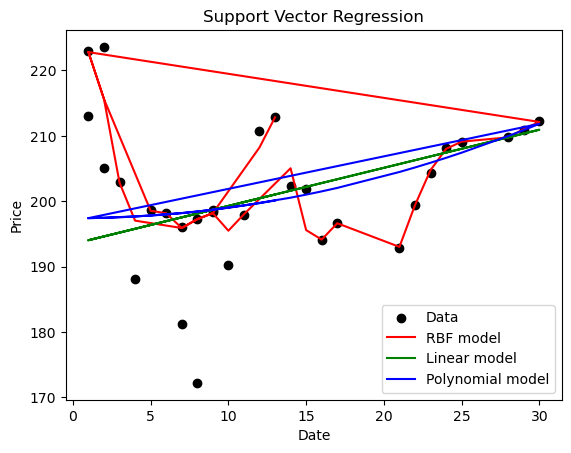

<function predict_prices at 0x00000196C27A9940>


In [43]:
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

dates = []
prices = []

def get_data(filename):
    with open(filename, 'r') as csvfile:
        csvFileReader = csv.reader(csvfile)
        next(csvFileReader)  # Skip header
        for row in csvFileReader:
            # Assuming the first column is a date in 'YYYY-MM-DD' format
            # Use the day as the feature for regression
            try:
                day = int(row[0].split('-')[2])
                price = float(row[1])
                dates.append(day)
                prices.append(price)
            except (IndexError, ValueError):
                # Skip rows with invalid data
                continue
    return

def predict_prices(dates, prices, x):
    dates = np.reshape(dates, (len(dates), 1))
    x = np.array(x).reshape(-1, 1)  # Ensure x is 2D

    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=2)
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin.fit(dates, prices)
    svr_poly.fit(dates, prices)
    svr_rbf.fit(dates, prices)

    plt.scatter(dates, prices, color='black', label='Data')
    plt.plot(dates, svr_rbf.predict(dates), color='red', label='RBF model')
    plt.plot(dates, svr_lin.predict(dates), color='green', label='Linear model')
    plt.plot(dates, svr_poly.predict(dates), color='blue', label='Polynomial model')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Support Vector Regression')
    plt.legend()
    plt.show()

    return svr_rbf.predict(x)[0], svr_lin.predict(x)[0], svr_poly.predict(x)[0]

get_data('AAPL_30d.csv')

predicted_price = predict_prices(dates, prices, [29])  # Pass as list

print(predict_prices)



Some features of this SVR model includes:

- **Data Points**: They show daily price values on the y-axis (Price) for each day of the month (x-axis). You can see some days with outliers that can confuse models.

- **RBF model**: From the model it looks very jagged and erratic. RBF is very sensitive to noise and can overfit wildly if not tuned properly. Due to bad generalization, it jumps up and down instead of producing a smooth curve.

- **Linear model**: A straight line across the data. Clearly underfits as it only captures an upward/downward trend, ignoring any wiggles or bends in the data. 

- **Polynomial model**: A curved line (quadratic).Fits the data better than the linear model, however its still too simplistic to capture the outliers. 


## 2: Using Synthetic Data Generation

### Importing Libraries

In [27]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    classification_report,
    roc_curve,
)

# Import SMOTE
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

### Preview the Data
If necessary, it’s important to clean the dataset at this step. For my project, I removed an unnecessary row and reorganized the column structure.

In [28]:
import pandas as pd
stock_data = pd.read_csv('AAPL_30d.csv', skiprows=2)  # skip the first two header rows

print("\nShape of the dataset (rows, columns):", stock_data.shape)
print("\nFirst 5 rows of the dataset:")
#Clean the data to present a more readable format
stock_data.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
print(stock_data.head())


Shape of the dataset (rows, columns): (30, 6)

First 5 rows of the dataset:
         Date       Close        High         Low        Open     Volume
0  2025-04-01  222.897705  223.387054  218.613315  219.522127   36412700
1  2025-04-02  223.596786  224.895087  220.730550  221.030160   35905900
2  2025-04-03  202.923904  207.218276  200.986443  205.270818  103419000
3  2025-04-04  188.133301  199.618240  187.094654  193.636079  125910900
4  2025-04-07  181.222366  193.895735  174.391312  176.967935  160466300


### Get a Summary Of the Data

In [29]:
print("\nDetailed information about the stock data:")
print(stock_data.info())

#check for missing values
print("\nMissing values in each column:")
print(stock_data.isnull().sum())


Detailed information about the stock data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    30 non-null     object 
 1   Close   30 non-null     float64
 2   High    30 non-null     float64
 3   Low     30 non-null     float64
 4   Open    30 non-null     float64
 5   Volume  30 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ KB
None

Missing values in each column:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


Since the dataset contains no missing values, we can now proceed to examining the individual column features. This includes:

- **Date**: The calendar date on which the stock data was recorded.
- **Close**: The stock price at the end of the trading day.
- **High**: The highest price the stock reached during the trading day.
- **Low**: The lowest price the stock reached during the trading day.
- **Open**: The stock price at the beginning of the trading day.
- **Volume**: The total number of shares traded during the day. 

### Analyzing the Class Distribution for Imbalance

This means checking whether the target variable (or label) in your dataset is imbalanced- that is, whether one class occurs far more often than another. This can affect model performance and may even contribute to **overfitting** if not handled properly.



Class Distribution in 'Close' column:
Close
170.0     1
180.0     1
190.0     4
200.0    13
210.0     9
220.0     2
Name: count, dtype: int64


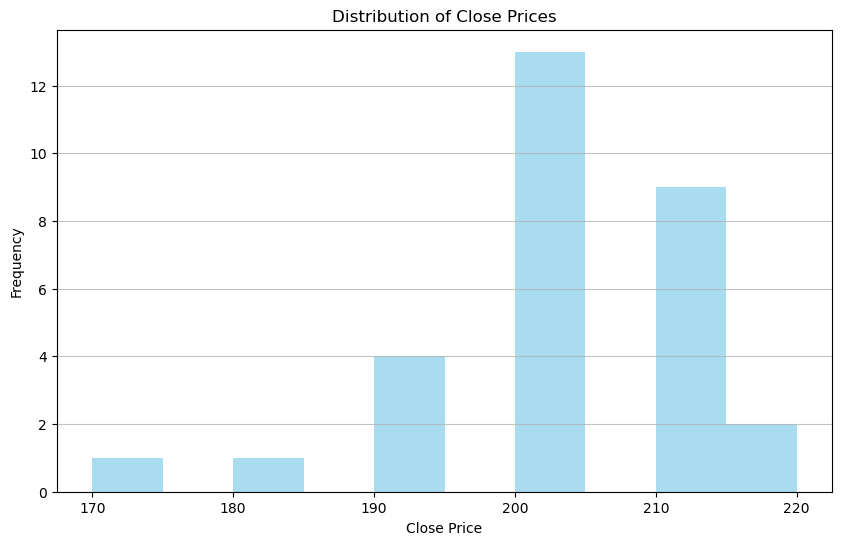

In [30]:
#Round Close prices
stock_data['Close'] = (stock_data['Close'] / 10).round() * 10 #round to nearest 10

#Class Counts in the 'Close' column
class_counts = stock_data['Close'].value_counts().sort_index()
print("\nClass Distribution in 'Close' column:")
print(class_counts)

# Visualize the distribution of the 'Close' column
plt.figure(figsize=(10, 6))
plt.hist(stock_data['Close'], bins=10, color='skyblue', alpha=0.7)
plt.xlabel('Close Price') #Set x-axis label
plt.ylabel('Frequency') #Set y-axis label
plt.grid(axis='y', alpha=0.75) # Add grid lines to y-axis add clarity
plt.title('Distribution of Close Prices')
plt.show()


### Separating Features and Target

Splitting your dataset into inputs (features) and outputs (target) allows me, the programmer, to better train and evaluate the machine learning model.

In [31]:
x = stock_data.drop(['Close', 'Date', 'Close'], axis=1)
y = stock_data['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(y.value_counts())


Close
200.0    13
210.0     9
190.0     4
220.0     2
180.0     1
170.0     1
Name: count, dtype: int64


### Scaling and Balancing the Training Data

Scaling prevents one feature from dominating the learning process. Balancing the classes ensures that the model can learn equally well from all the classes, and prevents any sort of bias towards the most common one. 


In [32]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
# Fit only on training data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("Orginal class distribution:")
print(y_train.value_counts())

min_class_size = y_train.value_counts().min()
print(f"Smallest class size: {min_class_size}")

if min_class_size > 1:
    smote = SMOTE(random_state=42, k_neighbors=1)
    x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)
    print("Class distribution after SMOTE:")
    print(y_train_smote.value_counts())
else:
    print("Some classes have only one sample, skipping SMOTE.")



Orginal class distribution:
Close
210.0    8
200.0    8
190.0    4
220.0    2
180.0    1
170.0    1
Name: count, dtype: int64
Smallest class size: 1
Some classes have only one sample, skipping SMOTE.


Since SMOTE requires at least 2 samples per class to work, classes 170.0 and 180.0 cause an error. To fix this error, removing classes or merging low-frequency classes together would be an appropriate solution.

### Merging Classes 

In [33]:
y_train = y_train.replace({170.0: 180.0})
print(y_train.value_counts())

Close
210.0    8
200.0    8
190.0    4
220.0    2
180.0    2
Name: count, dtype: int64


### Reapply SMOTE to the Training Data

Before SMOTE:
Close
210.0    8
200.0    8
190.0    4
220.0    2
180.0    2
Name: count, dtype: int64

After SMOTE:
Close
210.0    8
200.0    8
220.0    8
180.0    8
190.0    8
Name: count, dtype: int64


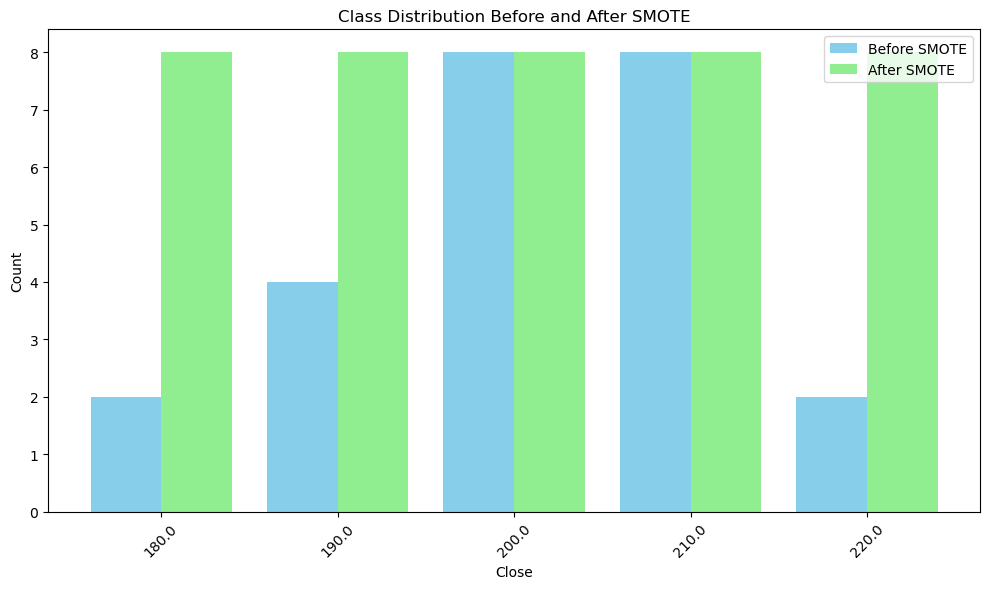

In [41]:


# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

# Print class distributions
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

# Plot distributions
classes = sorted(set(y_train) | set(y_train_smote))
x = np.arange(len(classes))  # x locations for the bars

counts_before = y_train.value_counts().reindex(classes, fill_value=0)
counts_after = y_train_smote.value_counts().reindex(classes, fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, counts_before, width=0.4, label='Before SMOTE', color='skyblue')
plt.bar(x + 0.2, counts_after, width=0.4, label='After SMOTE', color='lightgreen')

plt.xlabel('Close')
plt.ylabel('Count')
plt.title('Class Distribution Before and After SMOTE')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
